# 

In [22]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score
import joblib
import matplotlib.pyplot as plt
import sys
sys.path.append('./src')

from src.data import load_data_part1, CustomAnalyzer
from src.eval import print_score
import pandas as pd
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split

In [23]:
X, y = load_data_part1()
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

svm_clf = LinearSVC(random_state=0, tol=1e-5, max_iter=20000, class_weight='balanced')
svm_clf.fit(X_train, y_train)

y_hat = svm_clf.predict(X_test)

100%|██████████| 14354/14354 [00:00<00:00, 32302.90it/s]


In [24]:
d = joblib.load("./part1_speaker_recognition/gridsearch/results/part1_hrscv_LogisticRegression.pkl")
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)
pipeline = d.best_estimator_
pipeline.fit(X_train, y_train)
print(y_train)
y_hat = pipeline.predict(X_test)

100%|██████████| 43059/43059 [00:03<00:00, 12147.69it/s]


[1 1 1 ... 1 1 1]


100%|██████████| 14354/14354 [00:01<00:00, 11397.55it/s]


In [25]:
def countValue(l):
    d = {-1:0, 1:0}
    for v in l:
        # d[v] = d.get(v, 0) + 1
        d[v] += 1
    return d

def windows_post(y, size=1, threshold=2):
    """
    Convolue sur la liste et regarde le nombre de voisin dans la fenêtre centré sur le point. 

    * Même nombre de valeur des deux cotés = frontière = ne pas changer la valeur
    * 
    """
    new_y = y.copy()
    for i in range(size, len(y) - size):
        window = y[i - size : i + size + 1]
        d = countValue(window)
        if d[-1] < d[1]:
            new_y[i] = 1
        elif d[-1] > d[1]:
            new_y[i] = -1
        else:
            pass
    return new_y

one_windows_y_hat = windows_post(y_hat)

two_windows_y_hat = windows_post(y_hat, size=2)

three_windows_y_hat = windows_post(y_hat, size=3)

four_windows_y_hat = windows_post(y_hat, size=4)

one_two_windows_y_hat = windows_post(one_windows_y_hat, size=2)

df = pd.DataFrame({
    "True Label": y_test,
    "Prediction": y_hat,
    # "Size=1": one_windows_y_hat,
    # "Size=2": two_windows_y_hat,
    # "Size=3": three_windows_y_hat,
    # "Size=4": four_windows_y_hat,
    # "size=1 then 2": one_two_windows_y_hat
})

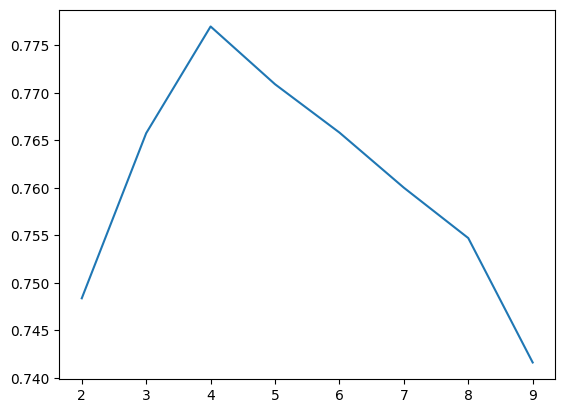

In [26]:
tmp = windows_post(y_hat)
lx, ly = [], []
for i in range(2, 10):
    tmp = windows_post(tmp, size=i)
    f1 = f1_score(y_test, tmp, pos_label=-1)
    lx.append(i)
    ly.append(f1)
plt.plot(lx, ly)


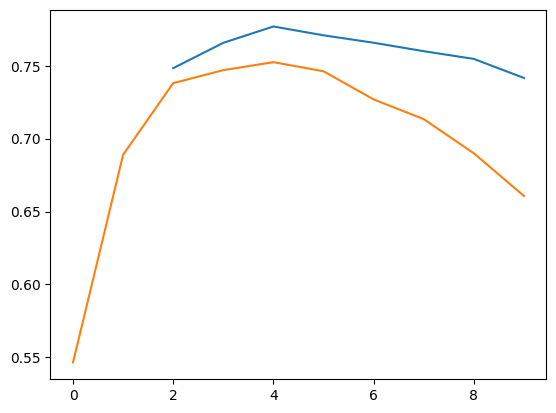

In [27]:
lx2, ly2 = [], []
for i in range(0, 10):
    tmp = windows_post(y_hat, size=i)
    f1 = f1_score(y_test, tmp, pos_label=-1)
    lx2.append(i)
    ly2.append(f1)
plt.plot(lx, ly)
plt.plot(lx2, ly2)

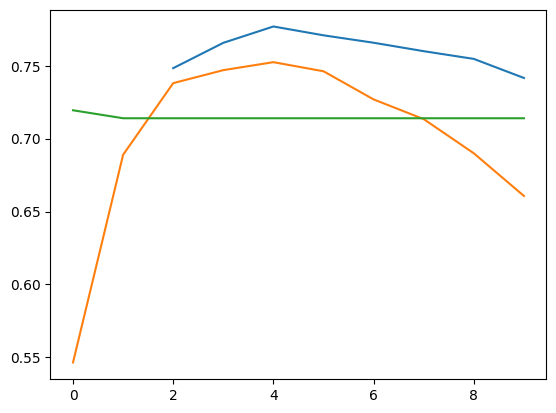

In [28]:
tmp = windows_post(y_hat, size=2)
lx3, ly3 = [], []
for i in range(0, 10):
    tmp = windows_post(tmp, size=i)
    f1 = f1_score(y_test, tmp, pos_label=-1)
    lx3.append(i)
    ly3.append(f1)
plt.plot(lx, ly)
plt.plot(lx2, ly2)
plt.plot(lx3, ly3)


    Best résult w/ postprocessing on test :
    =====
    Macro F1-score : 0.8700845084225414
    Micro F1-score : 0.9538804514421068
    Macro ROC-AUC: 0.8511754577044759
    Weighted ROC-AUC: 0.8511754577044759
    Classification report :
                  precision    recall  f1-score   support

          -1       0.82      0.72      0.77      1500
           1       0.97      0.98      0.97     12854

    accuracy                           0.95     14354
   macro avg       0.89      0.85      0.87     14354
weighted avg       0.95      0.95      0.95     14354

    =====
    


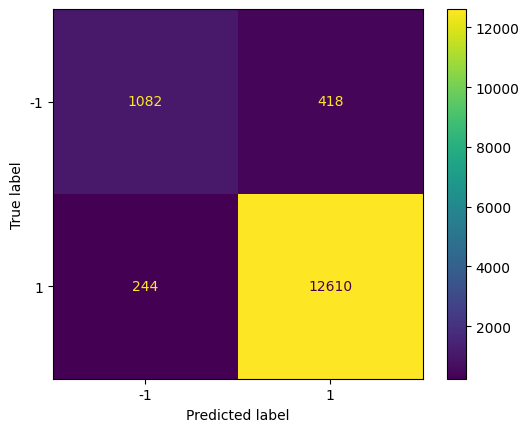

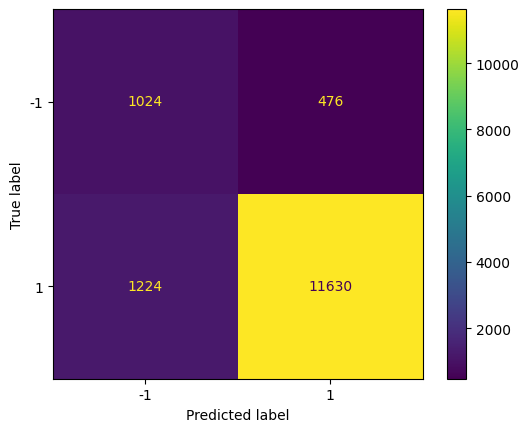

In [29]:
tmp = windows_post(y_hat)
for i in range(2, 4):
    tmp = windows_post(tmp, size=i)
print_score(y_test, tmp, "Best résult w/ postprocessing on test")
ConfusionMatrixDisplay(confusion_matrix(y_test, tmp), display_labels=pipeline.classes_).plot()
ConfusionMatrixDisplay(confusion_matrix(y_test, y_hat), display_labels=pipeline.classes_).plot()

On transforme surtout des -1 en 1. Il faudrait être plus sensible sur l'inverse

In [30]:
# C'est le résultat de la fonction de décision, si négatif on prédit -1, sinon 1 
confidence_score_test = pipeline.decision_function(X_test)
confidence_score_test = pd.Series(confidence_score_test)
df['confidence'] = confidence_score_test

100%|██████████| 14354/14354 [00:01<00:00, 10079.32it/s]


<AxesSubplot: >

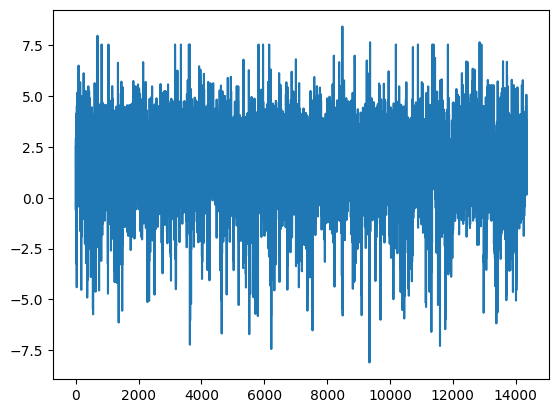

In [31]:
confidence_score_test.plot()

<AxesSubplot: >

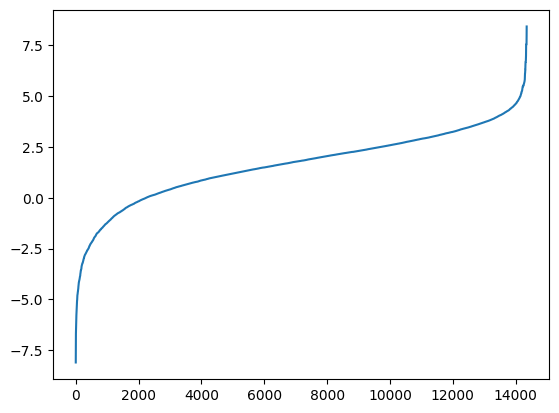

In [32]:
confidence_score_test.sort_values().reset_index(drop=True).plot()

In [33]:
confidence_score_test.describe()

count    14354.000000
mean         1.627607
std          1.796663
min         -8.094947
25%          0.680876
50%          1.813465
75%          2.814882
max          8.412547
dtype: float64

<AxesSubplot: >

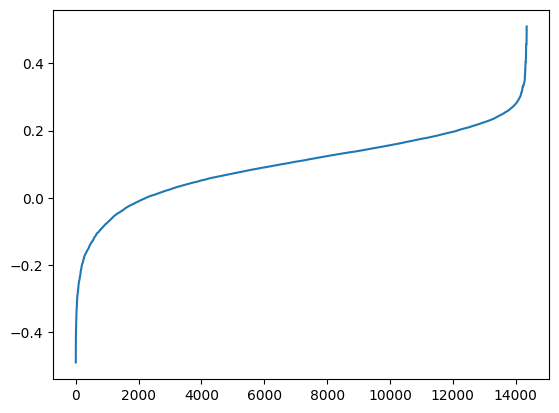

In [34]:
min_v = confidence_score_test.min()
mean_v = confidence_score_test.mean()
max_v = confidence_score_test.max()
conf_norm = pd.Series((confidence_score_test) / (max_v - min_v) )
conf_norm.sort_values().reset_index(drop=True).plot()

In [35]:
# C'est le résultat de la fonction de décision, si négatif on prédit -1, sinon 1 
confidence_score_train = pipeline.decision_function(X_train)
confidence_score_train = pd.Series(confidence_score_test)

100%|██████████| 43059/43059 [00:03<00:00, 12072.35it/s]


<AxesSubplot: >

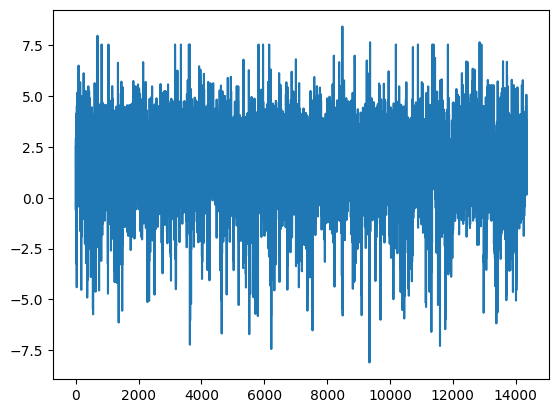

In [36]:
confidence_score_train.plot()

In [37]:
a = df['True Label'] == 1
b = df['True Label'] == -1
c = df['Prediction'] == 1
d = df['Prediction'] == -1

Bonne prédiction sur 1

In [38]:
df.loc[a & c, "confidence"].describe()

count    11630.000000
mean         2.235256
std          1.214077
min          0.001125
25%          1.335719
50%          2.168341
75%          3.027188
max          8.412547
Name: confidence, dtype: float64

Bonne prédiction sur -1

In [39]:
df.loc[b & d, "confidence"].describe()

count    1024.000000
mean       -2.064530
std         1.450564
min        -8.094947
25%        -2.838144
50%        -1.865650
75%        -0.914479
max        -0.004546
Name: confidence, dtype: float64

Mauvaise prédiction sur 1 (prédit -1 alors que 1)

In [40]:
df.loc[a & d, "confidence"].describe()

count    1224.000000
mean       -0.861998
std         0.770110
min        -4.755993
25%        -1.253275
50%        -0.659177
75%        -0.292799
max        -0.000007
Name: confidence, dtype: float64

Mauvaise prédiction sur -1 (prédit 1 alors que -1)

In [41]:
df.loc[b & c, "confidence"].describe()

count    476.000000
mean       1.125645
std        0.861987
min        0.000329
25%        0.412199
50%        0.932317
75%        1.615536
max        5.089572
Name: confidence, dtype: float64